In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ~/gscratch/athena_simulation_data/log/

/global/scratch2/sd/dorislee/athena_simulation_data/log


In [3]:
import sys
sys.path.remove('/global/homes/d/dorislee/.local/lib/python2.7/site-packages/yt-3.2.dev0-py2.7-linux-x86_64.egg')
sys.path.remove('/global/homes/d/dorislee/.local/lib/python2.7/site-packages')
sys.path.append('/global/homes/d/dorislee/mypythonpackages')

In [4]:
import h5py
import glob

In [16]:
filename="log.out1.00002.ath" #just read the athena hdf5 file not the xdmf file
h5f = h5py.File(filename, 'r+')

#### This simulation was 96x64x128 where I defined each meshblock to be 32x32x32 so that I have 24 meshblock one of each processor , making use of one full NUMA node on Hopper

In [36]:
"MeshBlock0".split?

In [40]:
"MeshBlock0"[9:]

'0'

In [37]:
num_lst = []
for i in h5f.keys():
    num_lst.append(i[9:])
print max(sort(np.array(num_lst,dtype="int")))+1

24


In [7]:
meshblock =h5f["MeshBlock0"]

In [8]:
meshblock.keys()

[u'press', u'rho', u'vel1', u'vel2', u'vel3', u'x1f', u'x2f', u'x3f']

In [9]:
x1f = meshblock["x1f"].value
print x1f
# plt.plot(x1f,'o') #linearly sampled series of r values in a meshblock

[ 0.2         0.20895773  0.21818419  0.22768743  0.2374758   0.24755779
  0.25794226  0.26863825  0.27965513  0.29100251  0.3026903   0.31472874
  0.32712832  0.3398999   0.35305464  0.366604    0.38055986  0.39493439
  0.40974012  0.42499006  0.44069749  0.45687616  0.47354016  0.49070409
  0.50838292  0.52659214  0.54534763  0.56466579  0.58456349  0.60505813
  0.6261676   0.64791036  0.67030543]


$$r_i = \frac{(r_+ + r_-)}{2}$$

In [10]:
n = 0#for cell number n

In [11]:
ri = (x1f[n]+x1f[n+1])/2.
print ri

0.204478859901


In [12]:
dri = abs(x1f[n]-x1f[n+1])
print dri

0.00895773


Computing the r,$\theta$ surface density ~~over the whole $\phi_i$ slice~~ per cell
$$\Delta Si,j,k =\int\int r drd\theta = r_i\Delta r_i\Delta \theta_j$$

total of 64 meshblocks spanning from $\theta$=0.32 to 2.79 radian and 32 zones per Meshblock

In [13]:
# (2.79252680319-0.34906585039)/64.*32

In [14]:
x2f = meshblock["x2f"].value
print x2f

[ 0.34906584  0.38724494  0.42542401  0.46360308  0.50178218  0.53996122
  0.57814032  0.61631942  0.65449846  0.69267756  0.7308566   0.7690357
  0.8072148   0.84539384  0.88357294  0.92175204  0.95993108  0.99811018
  1.03628922  1.07446837  1.11264741  1.15082645  1.18900549  1.22718465
  1.26536369  1.30354273  1.34172189  1.37990093  1.41807997  1.45625913
  1.49443817  1.53261721  1.57079637]


In [15]:
thetai = (x2f[n]+x2f[n+1])/2.
print thetai
dthetai = abs(x2f[n]-x2f[n+1])
print dthetai

0.368155390024
0.0381791


Checked that these are the same

In [16]:
# dS = ri*dri*dthetai
# print "The surface area per cell is :", dS

$$D(\phi) = \text{surface density} =\int \rho r^2sin\theta dr d\theta d\phi=\Sigma\Sigma\rho\frac{\Delta V_{cell}}{\Delta \phi} $$

In [17]:
density= meshblock["rho"].value#density for each meshblock
N_r = density.shape[0]
N_theta=density.shape[1]
N_phi= density.shape[2]

Summing over a $r,\theta$ slice of density: 

In [18]:
D_mblock = []
for phi_i in np.arange(N_phi):
    D_mblock.append(sum(density[:,:,phi_i-1]*ri**2*sin(thetai)*dri*dthetai))
print "We have", len(D_mblock),"values of D(phi) for this MeshBlock"

We have 32 values of D(phi) for this MeshBlock


pretty low, but makes sense because this is outside the torus so gas pressure is suppose to be low (e-5)..

Computing $D(\phi)$ for all 128 values of $\phi$

In [ ]:
NUM_MESHBLOCK=24
D = np.zeros(128)
for M in np.arange(NUM_MESHBLOCK):
    meshblock =h5f["MeshBlock{}".format(M)]
    for n in np.arange(N_phi):
        loc = meshblock.attrs["LogicalLocation"]
        phi_i =n+32*loc[2]
        density= meshblock["rho"].value#density for each meshblock
        N_phi= density.shape[2]
        #Compute D_i in each meshblock
        x1f = meshblock["x1f"].value
        x2f = meshblock["x2f"].value
        m=[]#mass summed over r,theta per density slice
        for ri in np.arange(N_r):
            for ti in np.arange(N_theta):
                ri = (x1f[ri]+x1f[ri+1])/2.
                dri = abs(x1f[ri]-x1f[ri+1])
                thetai = (x2f[ti]+x2f[ti+1])/2.
                dthetai = abs(x2f[ti]-x2f[ti+1])
                m.append(density[ri,ti,n]*(ri**2)*sin(thetai)*dri*dthetai)
        D[phi_i]=D[phi_i]+sum(m)

In [ ]:
D

In [ ]:
len(D)

In [ ]:
# plt.plot(np.arange(128),D)
plt.plot(D)
plt.xlabel("N")
plt.ylabel("density")

In [ ]:
# np.fft.fft(D)

In [ ]:
plt.plot(np.fft.fft(D))
plt.xlim(0,128)

### Fastest growing mode (m=1)

In [ ]:
amp = float(real(max(np.fft.fft(D))))
print amp

In [ ]:
3*2*4*32

32 meshblocks in phi direction(spanning 128 zones) and 32 cells in each meshblock

In [ ]:
density= meshblock["rho"].value#density for each meshblock

<matplotlib.colorbar.Colorbar instance at 0x2b672fc0c878>

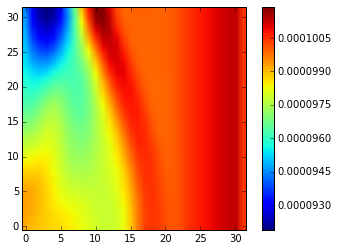

In [85]:
plt.imshow(density[5,:,:],origin="lower")
plt.colorbar()

In [95]:
# for z in np.arange(32):
#     plt.figure()
#     plt.imshow(density[:,:,z],origin="lower")
#     plt.colorbar()

In [98]:
# for x in np.arange(32):
#     plt.figure()
#     plt.imshow(density[x,:,:],origin="lower")
#     plt.colorbar()

In [99]:
density.shape

(32, 32, 32)

In [91]:
def compute_fastest_growing_mode(tstep_filename,debug=False):
    if debug: print "Working on {}".format(tstep_filename) 
    hdf5 = h5py.File(tstep_filename, 'r+')
    NUM_MESHBLOCK=24
    D = np.zeros(128)
    for M in np.arange(NUM_MESHBLOCK):
        meshblock =hdf5["MeshBlock{}".format(M)]
        density= meshblock["rho"].value#density for each meshblock
        N_r = density.shape[2]
        N_theta=density.shape[1]
        N_phi= density.shape[0]
        x1f = meshblock["x1f"].value
        x2f = meshblock["x2f"].value
#         plt.figure()
#         plt.imshow(density[10,:,:],origin="lower")
#         plt.colorbar()
        for n in np.arange(N_phi):
            loc = meshblock.attrs["LogicalLocation"]
            phi_i =n+32*loc[2]
            #Compute D_i in each meshblock
            m=0#mass summed over r,theta per density slice
            for ti in np.arange(N_theta):
                thetai = (x2f[ti]+x2f[ti+1])*0.5
                dthetai = abs(x2f[ti]-x2f[ti+1])
                for rii in np.arange(N_r):
                    #for each cell compute the coordinate to calculate the mass in each cell
                    ri = (x1f[rii]+x1f[rii+1])*0.5
                    dri = abs(x1f[rii]-x1f[rii+1])
#                     if m<density[n,ti,rii]:
#                         m=density[n,ti,rii]
                    m=m+density[n,ti,rii]*(ri*ri)*sin(thetai)*dri*dthetai
            D[phi_i]=D[phi_i]+m
#             if D[phi_i]<m:
#                 D[phi_i]=m
#                 print m
    if debug: print "D:",D
    plt.plot(D)
    amp = float(real(max(np.fft.fft(D))))
    if debug: print "amp:", amp
    return D

Working on log.out1.00356.ath5
D: [ 0.17981045  0.1772213   0.17482685  0.17264151  0.17066677  0.16890005
  0.16734682  0.1660094   0.16487765  0.1639428   0.16319595  0.16261741
  0.16218325  0.16188293  0.16170812  0.16164287  0.16167915  0.16180794
  0.16201996  0.1623143   0.16269244  0.16315331  0.16369054  0.1643085
  0.16501168  0.16580231  0.1666748   0.16763266  0.16868929  0.16984549
  0.17109588  0.17244956  0.17392591  0.17551433  0.17721063  0.17904413
  0.18101201  0.1830961   0.18532904  0.18773088  0.19027256  0.19296912
  0.19586008  0.19892329  0.20214058  0.205538    0.20912459  0.21288399
  0.21681365  0.22092216  0.22518907  0.22959799  0.23414708  0.23882983
  0.24363537  0.24854993  0.2535575   0.25863938  0.26377811  0.26895869
  0.27416827  0.2793942   0.28462155  0.28983225  0.29500832  0.30013337
  0.30519176  0.31016764  0.31504283  0.31979444  0.32440387  0.32886465
  0.3331594   0.33724563  0.34108994  0.34467908  0.3480027   0.35104354
  0.3537828   0.35

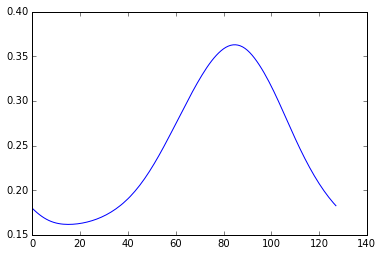

In [92]:
density= compute_fastest_growing_mode("log.out1.00356.ath5",True)

In [93]:
dens = np.fft.rfft(density)
damp = dens*np.conj(dens)

In [94]:
print sqrt(real(damp[0]))
print sqrt(real(damp[1]))
print sqrt(real(damp[2]))
print sqrt(real(damp[3]))
print sqrt(real(damp[4]))

31.4862482059
6.36602205345
1.06306928404
0.0561465399926
0.037207603842


(1.8301518029406065e-11, array(40.5262367850479))

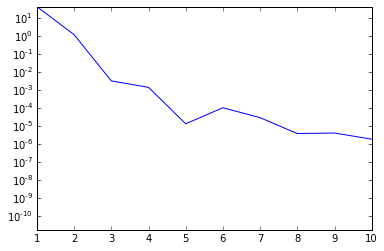

In [96]:
plt.semilogy(damp)
plt.xlim(1,10)
plt.ylim(0,real(damp[1]))

(0.25779121766620472, 0.25782052362579172)

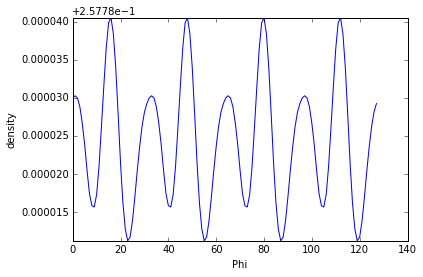

In [47]:
plt.plot(density)
plt.xlabel("Phi")
plt.ylabel("density")
plt.ylim(min(density),max(density))

On the log/ dataset, only goes till 16 orbits. In Hawley 1991, goes till 20 orbits then saturation

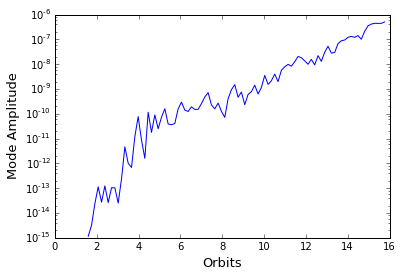

In [16]:
amp =  np.loadtxt("amp.txt")
t_orbits  = np.arange(len(amp))/2./np.pi
plt.ylabel("Mode Amplitude",fontsize=13)
plt.xlabel("Orbits",fontsize=13)
plt.semilogy(t_orbits,amp[:,1])

Using data  from athena/test_dfloor: 

In [83]:
from matplotlib.legend_handler import HandlerLine2D

In [97]:
cat amp.txt

32.994127312         0.0           0.0          0.0            0.0		0.0
32.9960779716         0.0           0.0          0.0            0.000149729272135		0.0
32.9989733846         0.0           0.0          0.0            0.000202475545859		0.0
33.0017993465         0.0           0.0          0.0            0.00011254823054		0.0
33.0041842437         0.0           0.0          0.0            0.000156702162798		0.0
33.0059210783         0.0           0.0          0.0            0.000378752341057		0.0
33.0082885645         0.0           0.0          0.0            0.000404676625371		0.0
33.0103940413         0.0           0.0          0.0            0.000241618817101		0.0
33.011175754         1.01652960566e-15           1.67419024808e-15          1.66016117907e-15            0.000183510020559		3.04378294408e-16
33.0115558557         0.0           5.4733995114e-14          0.0            0.000514754595141		0.0
33.0120745767         1.14602372474e-15           3.29533476747e-15          5

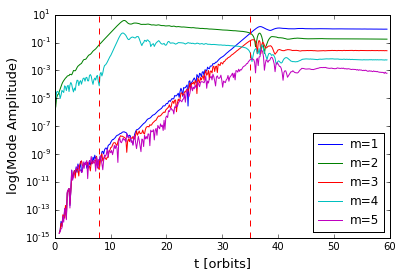

In [88]:
amp =  np.loadtxt("../../athena/test_dfloor/amp.txt")
t_orbits  = np.arange(len(amp))/2./np.pi
plt.ylabel("log(Mode Amplitude)",fontsize=13)
plt.xlabel("t [orbits]",fontsize=13)
# plt.semilogy(t_orbits,amp[:,1])
plt.semilogy(t_orbits,amp[:,1],label="m=1")
plt.semilogy(t_orbits,amp[:,2],label="m=2")
plt.semilogy(t_orbits,amp[:,3],label="m=3")
plt.semilogy(t_orbits,amp[:,4],label="m=4")
plt.semilogy(t_orbits,amp[:,5],label="m=5")
plt.axvline(x_min,color='r',linestyle="--")
plt.axvline(x_max,color='r',linestyle="--")
plt.legend(loc='lower right',prop={'size':12},numpoints=1)

Computing m=1 mode growth

In [89]:
m=1
x_min = 8
x_max =35
y_min = amp[x_min,:][m]
y_max = amp[x_max,:][m]
growth_rate = (y_max-y_min)/(x_max-x_min)
print growth_rate

9.60575262362e-12


In [27]:
mode_amp = []
for f in sort(glob.glob("log.out1.000*.ath")):
#     if f=="log.out1.00001.ath" or f=="log.out1.00100.ath":
    mode_amp.append(compute_fastest_growing_mode(f,False))

In [244]:
mode_amp

[10.081504613486587]

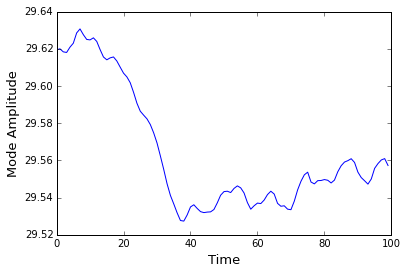

In [222]:
plt.plot(mode_amp)
plt.ylabel("Mode Amplitude",fontsize=13)
plt.xlabel("Time",fontsize=13)

To Do
- change code so that using MPICOMMWORLD ID or MESHBLOCK ID to initialize random seed